In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [173]:
df=pd.read_csv('app.csv',sep=";")

df['time'] = pd.to_datetime(df['time'])
print(df.dtypes)

df=df.set_index('time')
df.index=pd.to_datetime(df.index)
df

time        datetime64[ns]
users                int64
sessions             int64
newusers             int64
crashes              int64
dtype: object


,users,sessions,newusers,crashes
time,,,,
2018-12-22 09:00:00,64,60,5,0
2018-12-22 10:00:00,79,84,8,0
2018-12-22 11:00:00,97,102,22,0
2018-12-22 12:00:00,107,102,13,0
2018-12-22 13:00:00,105,117,10,2
...,...,...,...,...
2018-12-29 05:00:00,40,34,6,0
2018-12-29 06:00:00,48,41,8,0
2018-12-29 07:00:00,44,37,3,0


In [174]:
df.head()

,users,sessions,newusers,crashes
time,,,,
2018-12-22 09:00:00,64,60,5,0
2018-12-22 10:00:00,79,84,8,0
2018-12-22 11:00:00,97,102,22,0
2018-12-22 12:00:00,107,102,13,0
2018-12-22 13:00:00,105,117,10,2


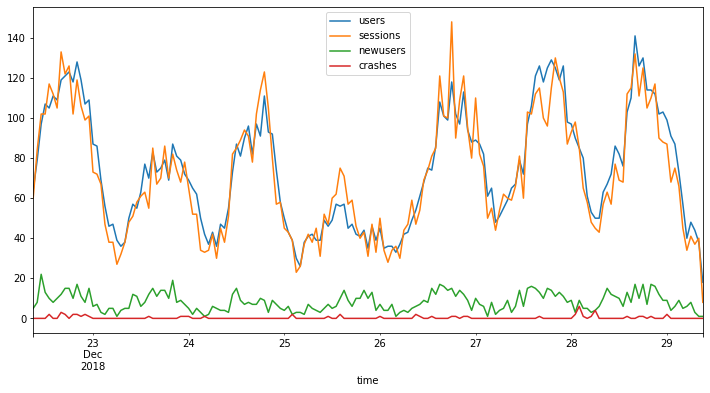

In [175]:
df.plot(figsize=(12,6))

In [176]:
from statsmodels.tsa.seasonal import seasonal_decompose

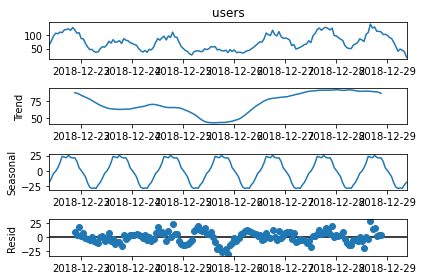

In [177]:
results = seasonal_decompose(df['users'])
results.plot();

In [178]:
len(df)

169

In [179]:
df=df.drop(columns=['sessions','newusers', 'crashes'])

In [180]:
train = df.iloc[:156]
test = df.iloc[156:]

In [181]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [182]:
df.head(),df.tail()

(                     users
 time                      
 2018-12-22 09:00:00     64
 2018-12-22 10:00:00     79
 2018-12-22 11:00:00     97
 2018-12-22 12:00:00    107
 2018-12-22 13:00:00    105,                      users
 time                      
 2018-12-29 05:00:00     40
 2018-12-29 06:00:00     48
 2018-12-29 07:00:00     44
 2018-12-29 08:00:00     38
 2018-12-29 09:00:00     18)

In [183]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [184]:
scaled_train[:10]

array([[0.33043478],
       [0.46086957],
       [0.6173913 ],
       [0.70434783],
       [0.68695652],
       [0.73913043],
       [0.72173913],
       [0.80869565],
       [0.82608696],
       [0.84347826]])

In [185]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [186]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [187]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.33043478 0.46086957 0.6173913 ]
Predict this y: 
 [[0.70434783]]


In [188]:
X.shape

(1, 3, 1)

In [189]:
# We do the same thing, but now instead for 12 months
n_input = 30
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [190]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [191]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [192]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 100)               40800     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [193]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
126/126 [==============================] - 7s 30ms/step - loss: 0.0412
Epoch 2/50
126/126 [==============================] - 2s 13ms/step - loss: 0.0281
Epoch 3/50
126/126 [==============================] - 2s 13ms/step - loss: 0.0196
Epoch 4/50
126/126 [==============================] - 2s 13ms/step - loss: 0.0162
Epoch 5/50
126/126 [==============================] - 2s 13ms/step - loss: 0.0111
Epoch 6/50
126/126 [==============================] - 2s 13ms/step - loss: 0.0096
Epoch 7/50
126/126 [==============================] - 2s 13ms/step - loss: 0.0086
Epoch 8/50
126/126 [==============================] - 2s 13ms/step - loss: 0.0083
Epoch 9/50
126/126 [==============================] - 2s 13ms/step - loss: 0.0090
Epoch 10/50
126/126 [==============================] - 2s 13ms/step - loss: 0.0082
Epoch 11/50
126/126 [==============================] - 2s 13ms/step - loss: 0.0079
Epoch 12/50
126/126 [==============================] - 2s 13ms/step - loss: 0.0077
Epoch 13/50
1

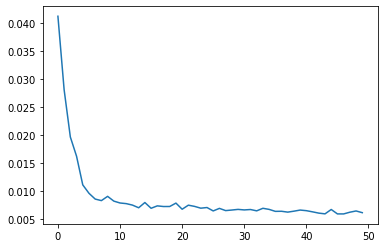

In [194]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [195]:
last_train_batch = scaled_train[-30:]

In [196]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [197]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 185ms/step


array([[0.70731366]], dtype=float32)

In [198]:
scaled_test[0]

array([0.74782609])

In [199]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 19ms/step


In [200]:
test_predictions

[array([0.70731366], dtype=float32),
 array([0.63778484], dtype=float32),
 array([0.56390214], dtype=float32),
 array([0.48737606], dtype=float32),
 array([0.4066213], dtype=float32),
 array([0.3225011], dtype=float32),
 array([0.25343093], dtype=float32),
 array([0.21069592], dtype=float32),
 array([0.20334849], dtype=float32),
 array([0.2285857], dtype=float32),
 array([0.27253878], dtype=float32),
 array([0.32767203], dtype=float32),
 array([0.3902751], dtype=float32)]

In [201]:
test.head()

,users
time,
2018-12-28 21:00:00,112
2018-12-28 22:00:00,102
2018-12-28 23:00:00,103
2018-12-29 00:00:00,99
2018-12-29 01:00:00,91


In [202]:
true_predictions = scaler.inverse_transform(test_predictions)

In [203]:
test['Predictions'] = true_predictions

<ipython-input-203-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


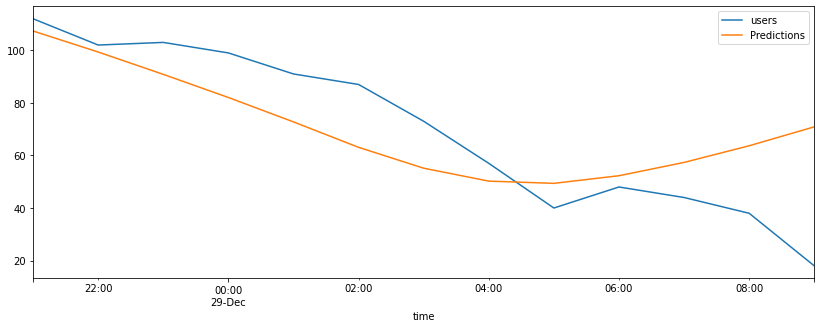

In [204]:
test.plot(figsize=(14,5))

In [205]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['users'],test['Predictions']))
print(rmse)

20.518996593268167
